In [69]:
import os
import gc
import logging
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import clone

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import cluster

In [2]:
%matplotlib inline

In [3]:
start_time = time.time()

In [4]:
train_df = pd.read_csv('../input/train.csv')

In [5]:
test_df = pd.read_csv('../input/test.csv')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [7]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [8]:
train_df.shape

(200000, 202)

In [9]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [10]:
'''
object_type_columns = []
int_type_columns = []
float_type_columns = []
for column_name in train_df.columns.tolist():
    is isinstance(train_df[column_name], pd)
'''

'\nobject_type_columns = []\nint_type_columns = []\nfloat_type_columns = []\nfor column_name in train_df.columns.tolist():\n    is isinstance(train_df[column_name], pd)\n'

In [11]:
train_df.dtypes

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
var_3      float64
var_4      float64
var_5      float64
var_6      float64
var_7      float64
var_8      float64
var_9      float64
var_10     float64
var_11     float64
var_12     float64
var_13     float64
var_14     float64
var_15     float64
var_16     float64
var_17     float64
var_18     float64
var_19     float64
var_20     float64
var_21     float64
var_22     float64
var_23     float64
var_24     float64
var_25     float64
var_26     float64
var_27     float64
            ...   
var_170    float64
var_171    float64
var_172    float64
var_173    float64
var_174    float64
var_175    float64
var_176    float64
var_177    float64
var_178    float64
var_179    float64
var_180    float64
var_181    float64
var_182    float64
var_183    float64
var_184    float64
var_185    float64
var_186    float64
var_187    float64
var_188    float64
var_189    float64
var_190    float64
var_191    f

In [12]:
train_df_id_droped = train_df[train_df.columns.drop('ID_code')]

In [13]:
train_df_cross_corelation_matrix = train_df_id_droped.corr()

In [14]:
#train_df_cross_corelation_matrix.corr?

In [15]:
train_df_cross_corelation_matrix.shape

(201, 201)

In [16]:
train_df_cross_corelation_matrix.max()

target     1.0
var_0      1.0
var_1      1.0
var_2      1.0
var_3      1.0
var_4      1.0
var_5      1.0
var_6      1.0
var_7      1.0
var_8      1.0
var_9      1.0
var_10     1.0
var_11     1.0
var_12     1.0
var_13     1.0
var_14     1.0
var_15     1.0
var_16     1.0
var_17     1.0
var_18     1.0
var_19     1.0
var_20     1.0
var_21     1.0
var_22     1.0
var_23     1.0
var_24     1.0
var_25     1.0
var_26     1.0
var_27     1.0
var_28     1.0
          ... 
var_170    1.0
var_171    1.0
var_172    1.0
var_173    1.0
var_174    1.0
var_175    1.0
var_176    1.0
var_177    1.0
var_178    1.0
var_179    1.0
var_180    1.0
var_181    1.0
var_182    1.0
var_183    1.0
var_184    1.0
var_185    1.0
var_186    1.0
var_187    1.0
var_188    1.0
var_189    1.0
var_190    1.0
var_191    1.0
var_192    1.0
var_193    1.0
var_194    1.0
var_195    1.0
var_196    1.0
var_197    1.0
var_198    1.0
var_199    1.0
Length: 201, dtype: float64

In [17]:
#train_df_cross_corelation_matrix.head()[:5]

In [18]:
train_df_cross_corelation_matrix.iloc[0, 0]

1.0

In [19]:
for i in range(201):
    train_df_cross_corelation_matrix.iloc[i, i] = 0

In [20]:
#train_df_cross_corelation_matrix.head()

In [21]:
train_df_cross_corelation_matrix.shape

(201, 201)

In [22]:
max_corr_all_features = train_df_cross_corelation_matrix.max()

In [23]:
max_corr_all_features

target     0.066731
var_0      0.052390
var_1      0.050343
var_2      0.055870
var_3      0.011055
var_4      0.010915
var_5      0.030979
var_6      0.066731
var_7      0.005093
var_8      0.019584
var_9      0.005951
var_10     0.005590
var_11     0.022993
var_12     0.008591
var_13     0.007843
var_14     0.005557
var_15     0.017283
var_16     0.008117
var_17     0.004278
var_18     0.043479
var_19     0.011291
var_20     0.006123
var_21     0.007166
var_22     0.060558
var_23     0.007298
var_24     0.028477
var_25     0.013328
var_26     0.062422
var_27     0.005218
var_28     0.005621
             ...   
var_170    0.047973
var_171    0.014873
var_172    0.008936
var_173    0.042022
var_174    0.009490
var_175    0.021692
var_176    0.007469
var_177    0.006667
var_178    0.005664
var_179    0.050002
var_180    0.031190
var_181    0.013714
var_182    0.006446
var_183    0.009359
var_184    0.048315
var_185    0.005879
var_186    0.006822
var_187    0.014873
var_188    0.007765


In [24]:
min_corr_all_features = train_df_cross_corelation_matrix.min()

In [25]:
min_corr_all_features

target    -0.080917
var_0     -0.007402
var_1     -0.008855
var_2     -0.008795
var_3     -0.007140
var_4     -0.007080
var_5     -0.005686
var_6     -0.008958
var_7     -0.005396
var_8     -0.005311
var_9     -0.042805
var_10    -0.008002
var_11    -0.006064
var_12    -0.069489
var_13    -0.055156
var_14    -0.006332
var_15    -0.006735
var_16    -0.006676
var_17    -0.004846
var_18    -0.007355
var_19    -0.006815
var_20    -0.018329
var_21    -0.058483
var_22    -0.007158
var_23    -0.025473
var_24    -0.006770
var_25    -0.005232
var_26    -0.009844
var_27    -0.005143
var_28    -0.023942
             ...   
var_170   -0.007749
var_171   -0.007080
var_172   -0.037976
var_173   -0.005893
var_174   -0.061669
var_175   -0.006886
var_176   -0.006647
var_177   -0.036863
var_178   -0.019681
var_179   -0.008394
var_180   -0.005537
var_181   -0.006153
var_182   -0.007198
var_183   -0.005467
var_184   -0.005032
var_185   -0.005858
var_186   -0.030421
var_187   -0.005331
var_188   -0.034015


In [26]:
unstacked_corelations = train_df_cross_corelation_matrix.unstack().sort_values().drop_duplicates()

In [27]:
unstacked_corelations

target   var_81    -0.080917
         var_139   -0.074080
var_12   target    -0.069489
var_146  target    -0.063644
var_76   target    -0.061917
target   var_174   -0.061669
var_21   target    -0.058483
var_166  target    -0.057773
var_80   target    -0.057609
target   var_165   -0.055734
         var_13    -0.055156
         var_148   -0.055011
var_198  target    -0.053000
var_34   target    -0.052692
target   var_115   -0.050174
         var_109   -0.049926
         var_44    -0.049039
var_169  target    -0.048382
target   var_149   -0.047319
var_92   target    -0.046295
var_154  target    -0.046106
var_108  target    -0.044791
target   var_33    -0.044334
         var_192   -0.042858
         var_9     -0.042805
         var_122   -0.042461
         var_123   -0.040291
         var_107   -0.039997
         var_121   -0.039788
var_86   target    -0.039126
                      ...   
target   var_71     0.033607
         var_35     0.036567
         var_155    0.037240
var_95   targe

In [28]:
type(unstacked_corelations)

pandas.core.series.Series

In [29]:
#unstacked_corelations.index

In [30]:
var_0 = train_df.loc[:, 'var_0']

In [31]:
unstacked_corelations.shape

(20101,)

In [32]:
'''
for column_name in train_df.columns.drop(['ID_code', 'target']):
    column = train_df.loc[:, column_name]
    print("{}: max {}, min {}, mean {}, median {}, mode {}, shape[0] {}, uniques.shape[0] {}, isnan {} \n".format(
        column_name,
        column.max(),
        column.min(),
        column.mean(),
        column.median(),
        column.mode()[0],
        column.shape[0],
        column.unique().shape[0],
        any(column.isna())
    ))
'''

'\nfor column_name in train_df.columns.drop([\'ID_code\', \'target\']):\n    column = train_df.loc[:, column_name]\n    print("{}: max {}, min {}, mean {}, median {}, mode {}, shape[0] {}, uniques.shape[0] {}, isnan {} \n".format(\n        column_name,\n        column.max(),\n        column.min(),\n        column.mean(),\n        column.median(),\n        column.mode()[0],\n        column.shape[0],\n        column.unique().shape[0],\n        any(column.isna())\n    ))\n'

In [33]:
'''
for column_name in train_df.columns.drop(['ID_code', 'target']):
    column = train_df.loc[:, column_name]
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(111)
    #column.hist()
    ax.hist(column, bins=200)
    #ax.bar(column)
    ax.set_title(column_name)
    plt.show()
'''

"\nfor column_name in train_df.columns.drop(['ID_code', 'target']):\n    column = train_df.loc[:, column_name]\n    fig = plt.figure(figsize=(18, 16))\n    ax = fig.add_subplot(111)\n    #column.hist()\n    ax.hist(column, bins=200)\n    #ax.bar(column)\n    ax.set_title(column_name)\n    plt.show()\n"

In [34]:
any(train_df_id_droped.isna())

True

In [35]:
'''
columns_with_nan = []
columns_without_nan = []
for column_name in train_df_id_droped.columns.tolist():
    print(column_name, )
    if any(train_df_id_droped[column_name].isna()):
        columns_with_nan.append(column_name)
    else:
        columns_without_nan.append(column_name)
'''

'\ncolumns_with_nan = []\ncolumns_without_nan = []\nfor column_name in train_df_id_droped.columns.tolist():\n    print(column_name, )\n    if any(train_df_id_droped[column_name].isna()):\n        columns_with_nan.append(column_name)\n    else:\n        columns_without_nan.append(column_name)\n'

In [37]:
for i in range(201):
    train_df_cross_corelation_matrix.iloc[i, i] = 1

In [38]:
features_min_correlation = {}
for column_name in train_df_cross_corelation_matrix.columns.tolist():
    idxmin = train_df_cross_corelation_matrix.loc[:, column_name].abs().idxmin()
    features_min_correlation.update({(column_name, idxmin): train_df_cross_corelation_matrix.abs().loc[column_name, idxmin]})


In [ ]:
#train_df_cross_corelation_matrix.idxmin?

In [39]:
features_min_correlation_reverse = {}
for key, value in features_min_correlation.items():
    #print(key, value)
    features_min_correlation_reverse.update({value: key})

In [40]:
sorted_min_correlations_values = sorted(features_min_correlation_reverse.keys())
#print(sorted_min_correlations_values)

In [41]:
min_of_min_correlated_features_10 = []
for value in sorted_min_correlations_values[:10]:
    #print(value)
    min_of_min_correlated_features_10.append(features_min_correlation_reverse[value])

In [42]:
print(min_of_min_correlated_features_10)

[('var_191', 'var_75'), ('var_173', 'var_6'), ('var_126', 'var_109'), ('var_144', 'var_27'), ('var_177', 'var_100'), ('var_181', 'var_12'), ('var_150', 'var_116'), ('var_142', 'var_44'), ('var_171', 'var_13'), ('var_69', 'var_126')]


In [43]:
min_of_min_correlated_features_10_names = set()
for names_pairs in min_of_min_correlated_features_10:
    min_of_min_correlated_features_10_names.add(names_pairs[0])
    min_of_min_correlated_features_10_names.add(names_pairs[1])

In [44]:
min_of_min_correlated_features_10_names
len(min_of_min_correlated_features_10_names)

19

In [45]:
train_df['var_0'].unique().shape

(94672,)

In [ ]:
#train_df.apply(pd.unique, axis=0)

In [46]:
uniques_dict = {column_name: train_df_id_droped[column_name].unique() for column_name in train_df_id_droped.columns.drop('target').tolist()}

In [47]:
uniques_dict_counts = {column_name: uniques.shape[0] for column_name, uniques in uniques_dict.items()}

In [48]:
uniques_counts_series = pd.Series(uniques_dict_counts)

In [49]:
uniques_counts_series[:5]

var_0     94672
var_1    108932
var_2     86555
var_3     74597
var_4     63515
dtype: int64

In [50]:
uniques_counts_series.unique().shape

(200,)

In [51]:
uniques_counts_series.max()

169968

In [ ]:
uniques_counts_series.min()

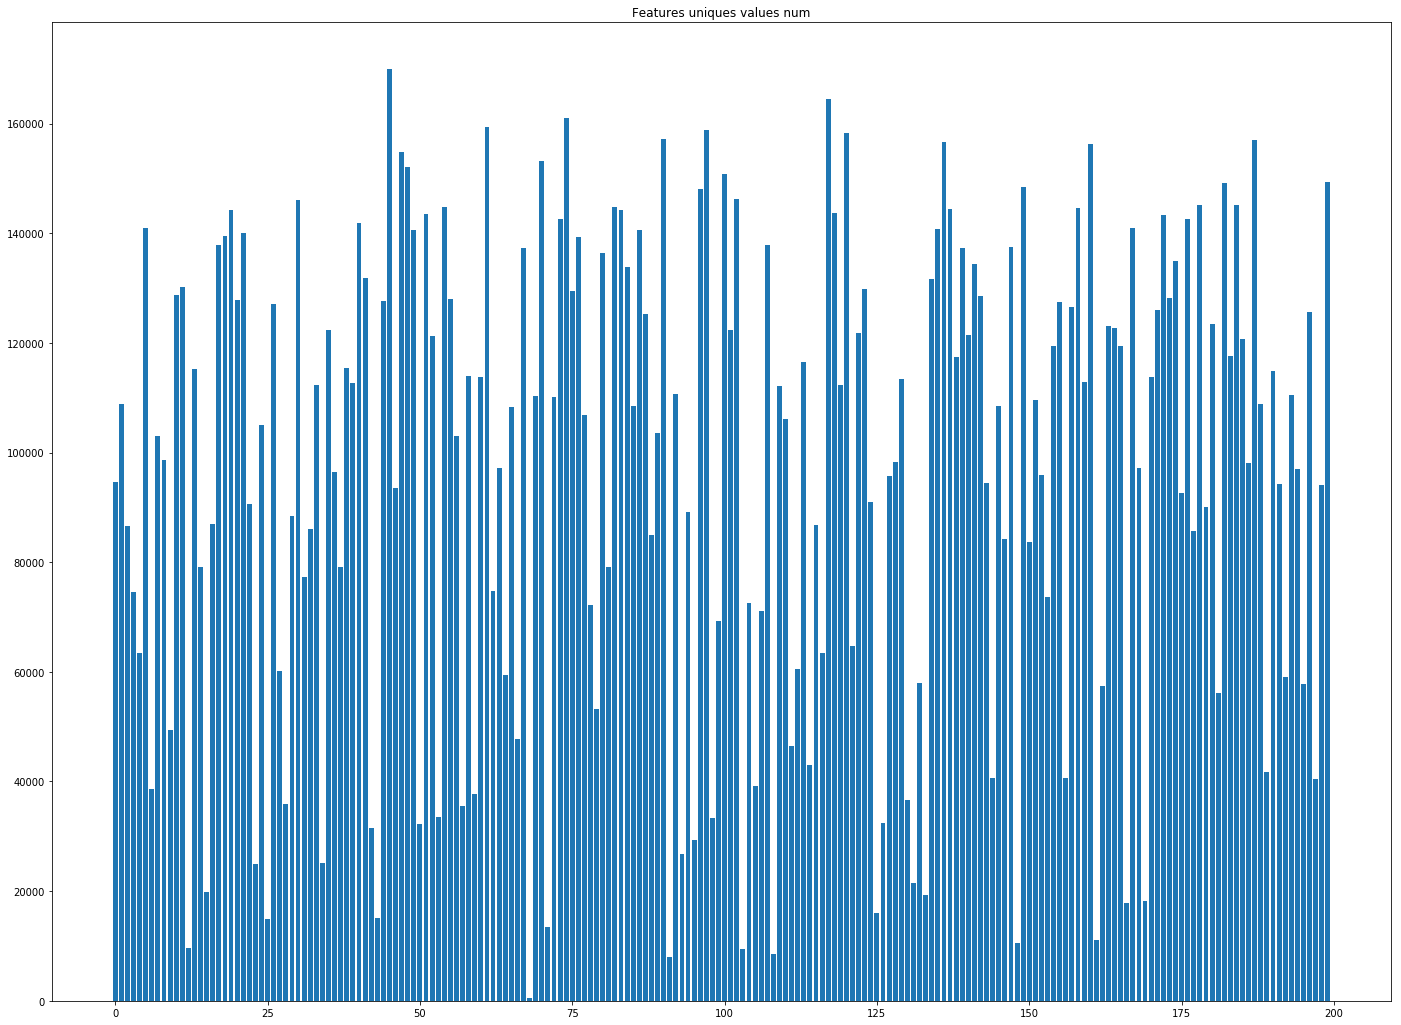

In [52]:
fig = plt.figure(figsize=(24, 18))
ax = fig.add_subplot(111)
ax.bar(np.arange(200), uniques_counts_series.values.astype(np.int64))
#ax.bar(uniques_counts_series)
ax.set_title('Features uniques values num')
plt.show()

In [53]:
all_cells_execution_time = time.time() - start_time
print("all cells execution time: {} min".format(all_cells_execution_time / 60))

all cells execution time: 11.535152316093445 min


In [54]:
train_df_id_droped.shape

(200000, 201)

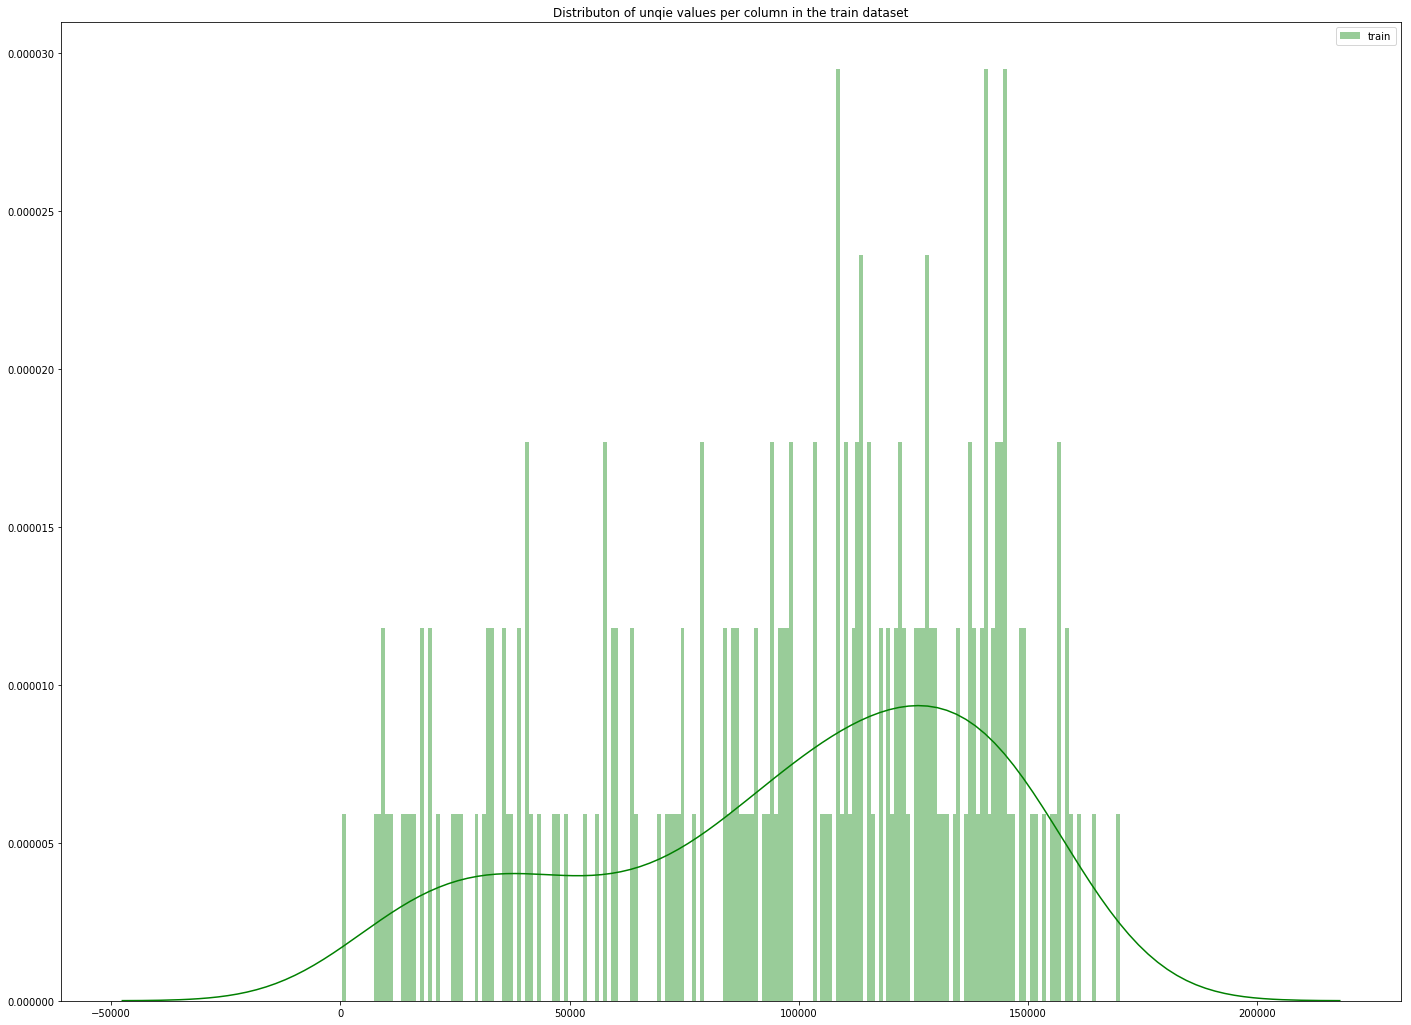

In [55]:
plt.figure(figsize=(24, 18))
plt.title("Distributon of unqie values per column in the train dataset")
#sns.distplot(train_df_id_droped[train_df_id_droped.columns.drop('target').tolist()].unique(), color='green', kde=True, bins=200, label="train")
sns.distplot(uniques_counts_series.values.astype(np.int64), color='green', kde=True, bins=200, label="train")
plt.legend()
plt.show()

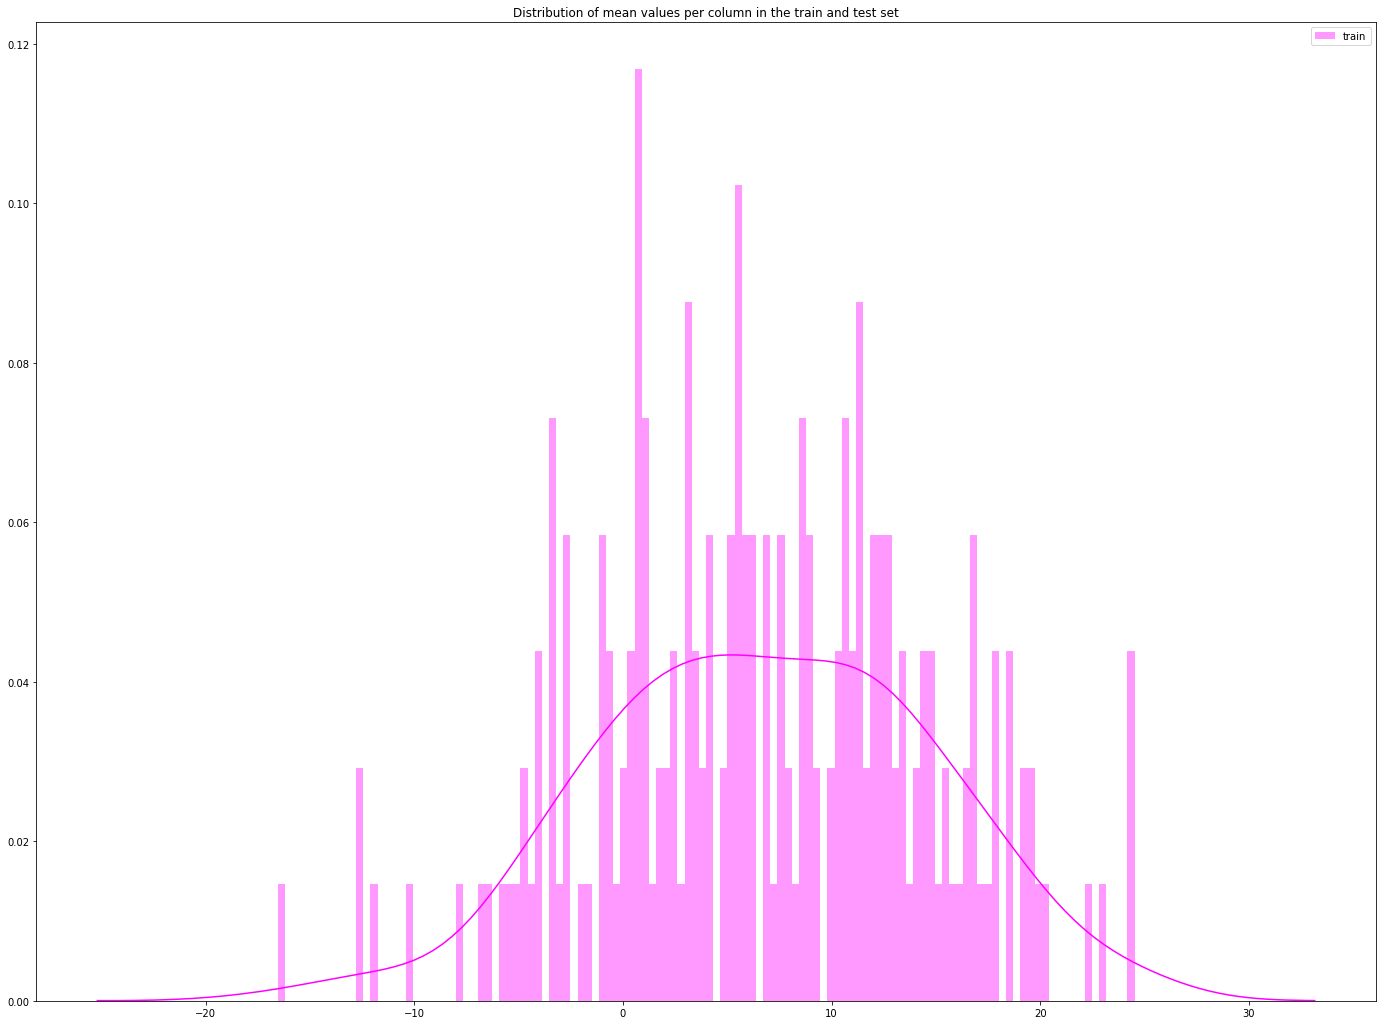

In [56]:
features = train_df.columns.values[2:202]
plt.figure(figsize=(24, 18))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0), color="magenta", kde=True,bins=120, label='train')
#sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

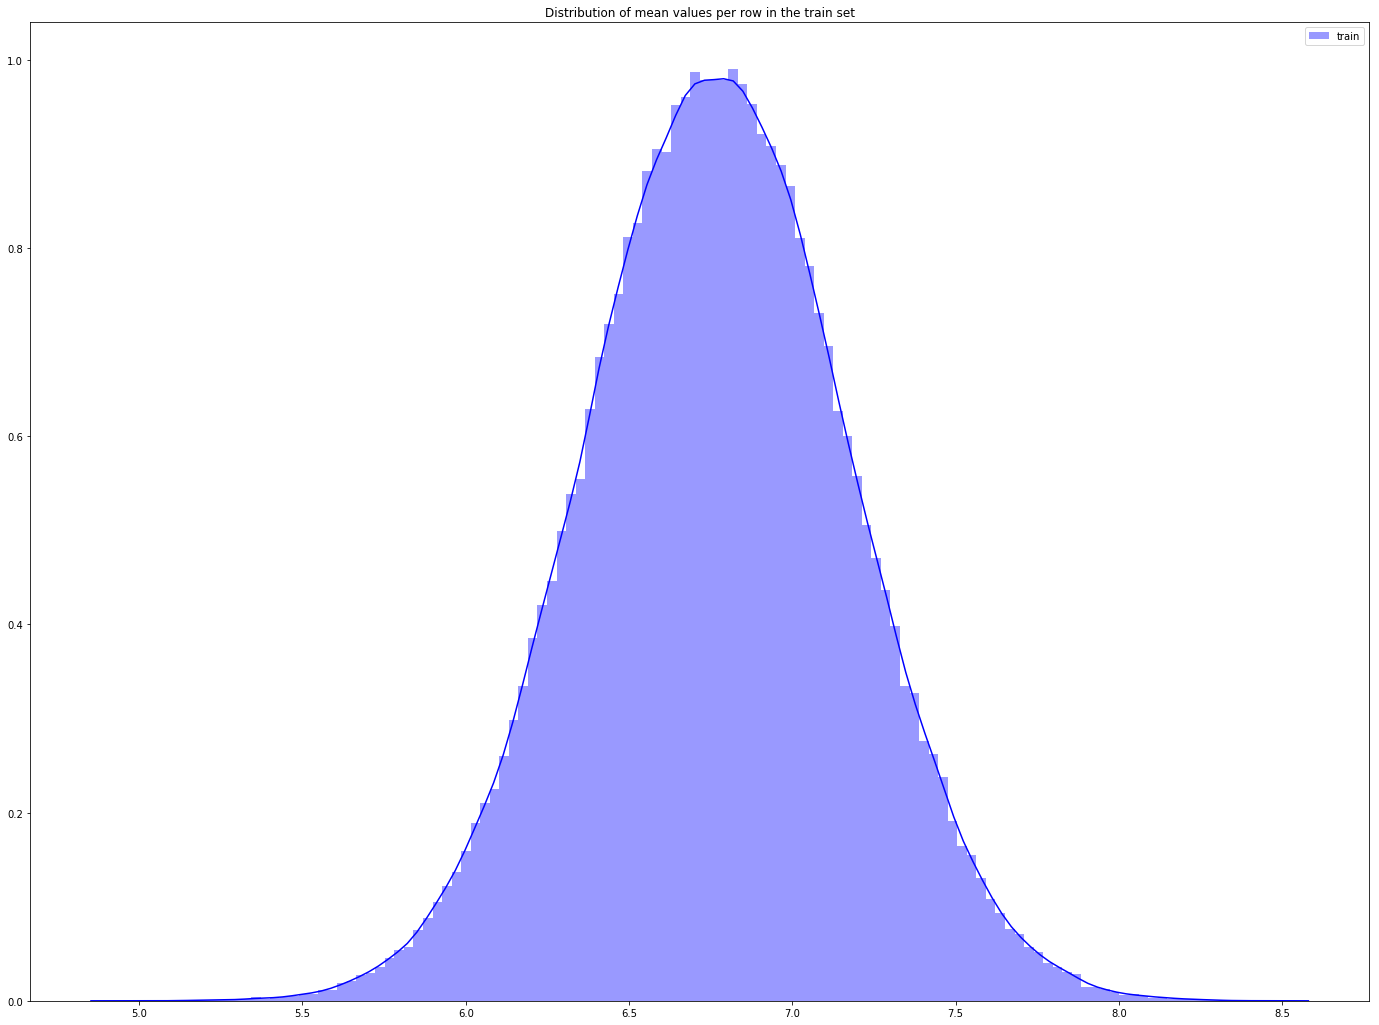

In [57]:
plt.figure(figsize=(24, 18))
features = train_df.columns.values[2:202]
#plt.title("Distribution of mean values per row in the train and test set")
plt.title("Distribution of mean values per row in the train set")
sns.distplot(train_df[features].mean(axis=1), color="blue", kde=True, bins=120, label='train')
#sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [58]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

In [59]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [60]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=1000, early_stopping_rounds=3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = features
    fold_importance_df['importance'] = clf.feature_importance()
    fold_importance_df['fold'] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.89904	valid_1's auc: 0.880364
[2000]	training's auc: 0.911204	valid_1's auc: 0.888868
[3000]	training's auc: 0.91903	valid_1's auc: 0.893151
[4000]	training's auc: 0.924854	valid_1's auc: 0.896012
[5000]	training's auc: 0.929701	valid_1's auc: 0.897714
[6000]	training's auc: 0.933934	valid_1's auc: 0.898494
[7000]	training's auc: 0.93786	valid_1's auc: 0.898994
[8000]	training's auc: 0.941613	valid_1's auc: 0.89928
[9000]	training's auc: 0.945152	valid_1's auc: 0.899671
[10000]	training's auc: 0.948466	valid_1's auc: 0.899878
[11000]	training's auc: 0.951758	valid_1's auc: 0.900177
[12000]	training's auc: 0.954863	valid_1's auc: 0.899992
[13000]	training's auc: 0.957793	valid_1's auc: 0.899881
[14000]	training's auc: 0.96065	valid_1's auc: 0.899628
Early stopping, best iteration is:
[11045]	training's auc: 0.951908	valid_1's auc: 0.900223
Fold 1
Training until validation scores don't improve

[11000]	training's auc: 0.951843	valid_1's auc: 0.900587
[12000]	training's auc: 0.954894	valid_1's auc: 0.900639
Early stopping, best iteration is:
[9691]	training's auc: 0.947612	valid_1's auc: 0.900898
CV score: 0.90053 


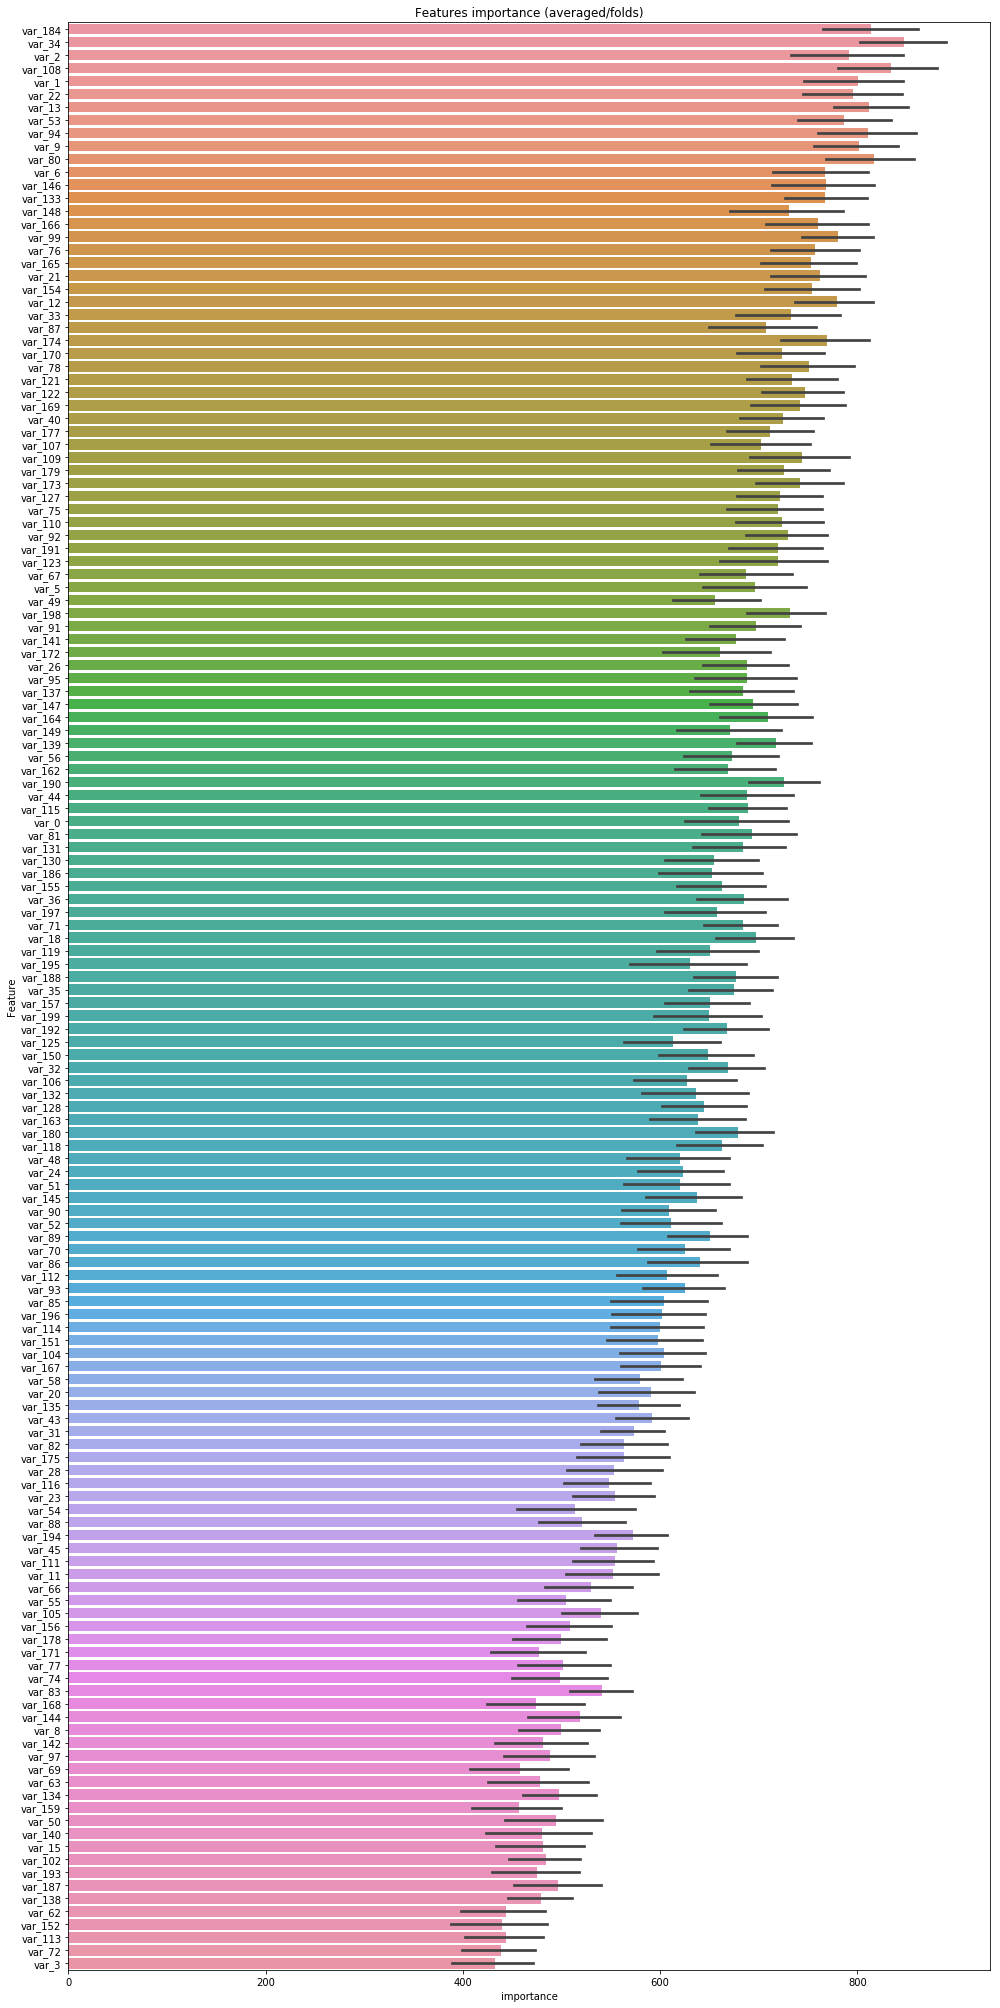

In [61]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [66]:
min_max_scaler = MinMaxScaler()

In [67]:
#scaled_train_values = min_max_scaler.fit_transform(train_df[train_df.columns.drop(['ID_code', 'target'])])

In [86]:
importnant_features = train_df[
    ['var_184', 'var_34', 'var_2', 'var_108', 'var_1', 'var_22', 'var_13', 'var_53', 'var_94', 'var_9', 'var_80', 'var_6', 'var_146', 'var_133', 'var_148', 'var_166', 'var_99']]

In [83]:
importnant_features.head()

,var_184,var_34,var_2,var_108,var_1,var_22,var_13,var_53,var_94,var_9,var_80,var_6,var_146,var_133
0,25.8398,11.1920,11.9081,14.1104,-6.7863,2.5791,0.5745,5.1736,14.8421,5.7470,13.6468,5.1187,11.5659,6.5674
1,22.5441,11.3702,13.8588,13.9550,-4.1473,8.5524,8.4135,6.6885,11.7569,8.0851,2.5462,5.6208,8.9231,7.0513
2,23.0866,11.0449,12.0805,14.1963,-2.7457,1.2145,7.3124,6.4059,14.2621,5.9525,7.4729,6.9427,11.4934,6.6231
3,-0.4639,10.6093,8.9522,14.3256,-2.1518,6.8202,11.9704,5.2091,7.2887,8.2450,0.7839,5.8428,10.4994,7.1954
4,11.8503,12.4057,12.8746,14.0837,-1.4834,10.1102,7.8895,5.7555,14.0553,7.6784,2.9598,5.9405,11.5670,6.6173


In [87]:
scaled_important_features_values = min_max_scaler.fit_transform(importnant_features)

In [71]:
bandwidth = cluster.estimate_bandwidth(
    scaled_important_features_values,
    quantile=0.1,
    n_samples=scaled_important_features_values.shape[0]
)

In [72]:
bandwidth

0.4840789109560282

In [ ]:
start_time = time.time()
ms = cluster.MeanShift(bandwidth=0.4, bin_seeding=True, n_jobs=10)
ms.fit(scaled_important_features_values)
print("Clustering time: {} min".format((time.time() - start_time) / 60))
labels = ms.labels_
cluster_centres = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("Количество кластеров: %d" % n_clusters_)

In [90]:
cluster_centres

array([[0.48645646, 0.47211457, 0.48578737, 0.5113574 , 0.52191852,
        0.47565844, 0.53006853, 0.54258419, 0.49837396, 0.5216777 ,
        0.50632781, 0.49584103, 0.50145414, 0.4875746 , 0.47558533,
        0.47273967, 0.51917697],
       [0.40106693, 0.09072575, 0.28086726, 0.04220907, 0.63116734,
        0.85371793, 0.39618101, 0.3284083 , 0.40765041, 0.5133494 ,
        0.07509414, 0.59933775, 0.40529438, 0.53474812, 0.33791803,
        0.44892791, 0.6501659 ],
       [0.39018441, 0.46238728, 0.50278198, 0.0709073 , 0.79651616,
        0.86847417, 0.09594039, 0.37829984, 0.88862961, 0.35988357,
        0.42711015, 0.42836535, 0.3709164 , 0.82653061, 0.42721497,
        0.41254432, 0.56436837],
       [0.87660593, 0.57123513, 0.43206331, 0.4357002 , 0.54844179,
        0.26319727, 0.07883186, 0.91419392, 0.83489106, 0.66117464,
        0.46648227, 0.83873189, 0.61770923, 0.42413045, 0.52782238,
        0.41604761, 0.51815165],
       [0.3931612 , 0.42098591, 0.75895079, 0.092702

In [91]:
type(labels)

numpy.ndarray

In [92]:
labels.shape

(200000,)

In [93]:
train_df_copy = train_df.copy()

In [94]:
train_df_copy is train_df

False

In [95]:
train_df_copy['cluster_labels'] = labels

In [96]:
train_df_copy['cluster_labels'].head()

0    0
1    0
2    0
3    0
4    0
Name: cluster_labels, dtype: int64

In [97]:
train_df_copy['cluster_labels'].unique()

array([0, 4, 1, 2, 3])

In [100]:
cluster_0 = train_df_copy[train_df_copy['cluster_labels'] == 0]

In [101]:
cluster_0 = train_df_copy[train_df_copy['cluster_labels'] == 1]

In [102]:
cluster_2 = train_df_copy[train_df_copy['cluster_labels'] == 2]

In [103]:
cluster_3 = train_df_copy[train_df_copy['cluster_labels'] == 3]

In [104]:
cluster_4 = train_df_copy[train_df_copy['cluster_labels'] == 4]

In [105]:
clusters = [train_df_copy[train_df_copy['cluster_labels'] == cluster_num] for cluster_num in range(0, 5)]    

In [109]:
for i, data_cluster in enumerate(clusters):
    print(data_cluster.shape)
    print(i, data_cluster[data_cluster['target'] == 1].shape)

(198065, 203)
0 (19470, 203)
(471, 203)
1 (144, 203)
(340, 203)
2 (143, 203)
(490, 203)
3 (132, 203)
(634, 203)
4 (209, 203)
